# Steps 
1. Read dataset
2. Scale the data
3. Create test and training sets
4. Define the LSTM and forward method
5. Train the model
6. Evaluate the model

In [70]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [71]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/g5XM0-gTrOquyZcBxcJAfw/StockData.csv")

In [72]:
df

,Unnamed: 0,Date,Open,High,Low,Close
0,0,2018-03-27,173.68,175.15,166.92,168.340
1,1,2018-03-26,168.07,173.10,166.44,172.770
2,2,2018-03-23,168.39,169.92,164.94,164.940
3,3,2018-03-22,170.00,172.68,168.60,168.845
4,4,2018-03-21,175.04,175.09,171.26,171.270
...,...,...,...,...,...,...
9395,9395,1980-12-18,26.63,26.75,26.63,26.630
9396,9396,1980-12-17,25.87,26.00,25.87,25.870
9397,9397,1980-12-16,25.37,25.37,25.25,25.250
9398,9398,1980-12-15,27.38,27.38,27.25,27.250


In [73]:
stock_data = df
stock_data["Date"] = pd.to_datetime(df.Date)
print(stock_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  9400 non-null   int64         
 1   Date        9400 non-null   datetime64[ns]
 2   Open        9400 non-null   float64       
 3   High        9400 non-null   float64       
 4   Low         9400 non-null   float64       
 5   Close       9400 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 440.8 KB
None


In [74]:
stock_data

,Unnamed: 0,Date,Open,High,Low,Close
0,0,2018-03-27,173.68,175.15,166.92,168.340
1,1,2018-03-26,168.07,173.10,166.44,172.770
2,2,2018-03-23,168.39,169.92,164.94,164.940
3,3,2018-03-22,170.00,172.68,168.60,168.845
4,4,2018-03-21,175.04,175.09,171.26,171.270
...,...,...,...,...,...,...
9395,9395,1980-12-18,26.63,26.75,26.63,26.630
9396,9396,1980-12-17,25.87,26.00,25.87,25.870
9397,9397,1980-12-16,25.37,25.37,25.25,25.250
9398,9398,1980-12-15,27.38,27.38,27.25,27.250


In [75]:
stock_data = stock_data.sort_values(by="Date")
stock_data

,Unnamed: 0,Date,Open,High,Low,Close
9399,9399,1980-12-12,28.75,28.87,28.75,28.750
9398,9398,1980-12-15,27.38,27.38,27.25,27.250
9397,9397,1980-12-16,25.37,25.37,25.25,25.250
9396,9396,1980-12-17,25.87,26.00,25.87,25.870
9395,9395,1980-12-18,26.63,26.75,26.63,26.630
...,...,...,...,...,...,...
4,4,2018-03-21,175.04,175.09,171.26,171.270
3,3,2018-03-22,170.00,172.68,168.60,168.845
2,2,2018-03-23,168.39,169.92,164.94,164.940
1,1,2018-03-26,168.07,173.10,166.44,172.770


In [76]:
price = stock_data[["Open", "High", "Low", "Close"]]
price

,Open,High,Low,Close
9399,28.75,28.87,28.75,28.750
9398,27.38,27.38,27.25,27.250
9397,25.37,25.37,25.25,25.250
9396,25.87,26.00,25.87,25.870
9395,26.63,26.75,26.63,26.630
...,...,...,...,...
4,175.04,175.09,171.26,171.270
3,170.00,172.68,168.60,168.845
2,168.39,169.92,164.94,164.940
1,168.07,173.10,166.44,172.770


In [77]:
scaler = MinMaxScaler(feature_range=(-1,1))
price_scaled = scaler.fit_transform(price.values)
price_scaled

array([[-0.94899391, -0.94884358, -0.94844388, -0.94863261],
       [-0.95295751, -0.95313783, -0.95280073, -0.95297352],
       [-0.95877273, -0.95893076, -0.95860987, -0.95876139],
       ...,
       [-0.54499559, -0.54233014, -0.55287044, -0.55450731],
       [-0.54592139, -0.53316521, -0.54851359, -0.53184778],
       [-0.52969087, -0.52725701, -0.54711939, -0.54466792]])

In [78]:
train_window = 7
def create_in_out_seq(price, tw):
    inout_seq = []
    L = len(price)
    print("Length: ", L)

    for i in range(L-tw):
        data_seq = price[i:i+tw]
        data_label = price[i+tw:i+tw+1][0][3]
        inout_seq.append((data_seq, data_label))

    data = inout_seq
    print('Size of data: ', len(data))

    test_size = 20
    train_size = len(data) - (test_size)
    print("train size: ", train_size)
    print("test size: ", test_size)

    train = data[:train_size]
    test = data[train_size:]
    train = train[:-(tw-1)]
    return train, test

train, test = create_in_out_seq(price_scaled, train_window)

Length:  9400
Size of data:  9393
train size:  9373
test size:  20


In [79]:
print(test[0])
print(test[1])

(array([[-0.53350981, -0.52820808, -0.53303223, -0.53283172],
       [-0.53440669, -0.52982203, -0.53404883, -0.5345102 ],
       [-0.53215004, -0.53022552, -0.5352397 , -0.53676747],
       [-0.53512997, -0.53071547, -0.5332065 , -0.53233975],
       [-0.5297198 , -0.52581598, -0.52789114, -0.52378816],
       [-0.52196618, -0.51503711, -0.52013593, -0.51390537],
       [-0.51401004, -0.51189567, -0.51447202, -0.51558385]]), -0.5163652148748373)
(array([[-0.53440669, -0.52982203, -0.53404883, -0.5345102 ],
       [-0.53215004, -0.53022552, -0.5352397 , -0.53676747],
       [-0.53512997, -0.53071547, -0.5332065 , -0.53233975],
       [-0.5297198 , -0.52581598, -0.52789114, -0.52378816],
       [-0.52196618, -0.51503711, -0.52013593, -0.51390537],
       [-0.51401004, -0.51189567, -0.51447202, -0.51558385],
       [-0.51354714, -0.51150659, -0.51479152, -0.51636521]]), -0.525394298943713)


In [80]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm= nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1, self.hidden_size),
                       )
        
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1,-1),hidden_cell)
        prediction = self.linear(lstm_out.view(len(input_seq), -1))
        return prediction[-1]

In [81]:
model = LSTM()
loss_ = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [82]:
from tqdm.notebook import tqdm

epochs = 5
for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in tqdm(train):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq) 

        labels = labels.view(1)

        single_loss = loss_(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    avg_loss = epoch_loss / len(train)
    print(f"Epoch: {i:3}, Loss: {avg_loss:.10f}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9367 [00:00<?, ?it/s]

Epoch:   0, Loss: 0.0016917319


  0%|          | 0/9367 [00:00<?, ?it/s]

Epoch:   1, Loss: 0.0008918128


  0%|          | 0/9367 [00:00<?, ?it/s]

Epoch:   2, Loss: 0.0009484789


  0%|          | 0/9367 [00:00<?, ?it/s]

Epoch:   3, Loss: 0.0009051524


  0%|          | 0/9367 [00:00<?, ?it/s]

Epoch:   4, Loss: 0.0008398964


In [83]:
model.eval()
actual, predict = [],[]

for seq,labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        predict.append(model(seq).item())

actual = np.array(actual)
predict = np.array(predict)

In [84]:
pred = torch.from_numpy(np.array(predict)).type(torch.Tensor)
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)

In [85]:
print(actual)
print(pred)

tensor([-0.5164, -0.5254, -0.5219, -0.5201, -0.5206, -0.5253, -0.5198, -0.5110,
        -0.5059, -0.5110, -0.5154, -0.5148, -0.5167, -0.5245, -0.5247, -0.5362,
        -0.5432, -0.5545, -0.5318, -0.5447])
tensor([-0.5406, -0.5407, -0.5443, -0.5455, -0.5433, -0.5425, -0.5455, -0.5431,
        -0.5403, -0.5377, -0.5383, -0.5407, -0.5405, -0.5415, -0.5446, -0.5441,
        -0.5479, -0.5507, -0.5542, -0.5490])


In [86]:
pred_new = scaler.inverse_transform(np.c_[np.zeros(20), np.zeros(20), np.zeros(20), np.array(pred)])
pred_new

array([[356.765     , 358.095     , 355.285     , 169.74797617],
       [356.765     , 358.095     , 355.285     , 169.72202472],
       [356.765     , 358.095     , 355.285     , 168.47001167],
       [356.765     , 358.095     , 355.285     , 168.05833113],
       [356.765     , 358.095     , 355.285     , 168.80136631],
       [356.765     , 358.095     , 355.285     , 169.07371231],
       [356.765     , 358.095     , 355.285     , 168.06720817],
       [356.765     , 358.095     , 355.285     , 168.87909707],
       [356.765     , 358.095     , 355.285     , 169.85997931],
       [356.765     , 358.095     , 355.285     , 170.73785903],
       [356.765     , 358.095     , 355.285     , 170.52942361],
       [356.765     , 358.095     , 355.285     , 169.70200504],
       [356.765     , 358.095     , 355.285     , 169.76424731],
       [356.765     , 358.095     , 355.285     , 169.45109988],
       [356.765     , 358.095     , 355.285     , 168.36599993],
       [356.765     , 358

In [87]:
actual_new = scaler.inverse_transform(np.c_[np.zeros(20), np.zeros(20), np.zeros(20), np.array(actual)])
actual_new

array([[356.765     , 358.095     , 355.285     , 178.11999474],
       [356.765     , 358.095     , 355.285     , 174.99999256],
       [356.765     , 358.095     , 355.285     , 176.21000958],
       [356.765     , 358.095     , 355.285     , 176.81999212],
       [356.765     , 358.095     , 355.285     , 176.67000924],
       [356.765     , 358.095     , 355.285     , 175.03000149],
       [356.765     , 358.095     , 355.285     , 176.94000725],
       [356.765     , 358.095     , 355.285     , 179.97999249],
       [356.765     , 358.095     , 355.285     , 181.71999569],
       [356.765     , 358.095     , 355.285     , 179.97000324],
       [356.765     , 358.095     , 355.285     , 178.44000078],
       [356.765     , 358.095     , 355.285     , 178.65000152],
       [356.765     , 358.095     , 355.285     , 178.0199993 ],
       [356.765     , 358.095     , 355.285     , 175.2999995 ],
       [356.765     , 358.095     , 355.285     , 175.24000223],
       [356.765     , 358

In [88]:
rmse = np.sqrt(mean_squared_error(actual_new, pred_new))
print("RMSE", rmse)

mae = mean_absolute_error(actual_new, pred_new)
print("MAE", mae)

RMSE 3.7512960212442965
MAE 1.7221129238978032


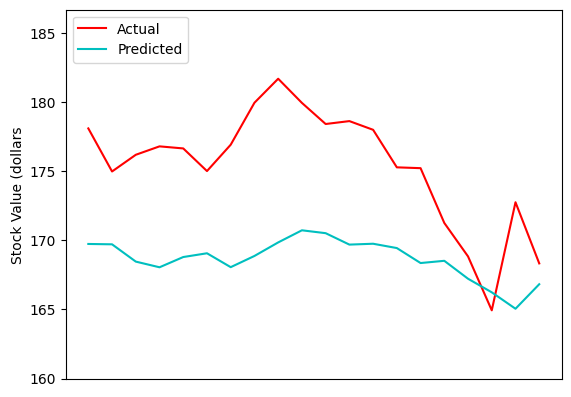

In [89]:
fig, ax = plt.subplots()

ax.plot(actual_new[:,3], 'r-', label="Actual")
ax.plot(pred_new[:,3], 'c-', label="Predicted")

ax.set_ylabel('Stock Value (dollars')

ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3])) - 5, max(max(actual_new[:,3]), max(pred_new[:,3])) + 5)
plt.xticks([])
    
ax.legend(loc='upper left')

plt.show()

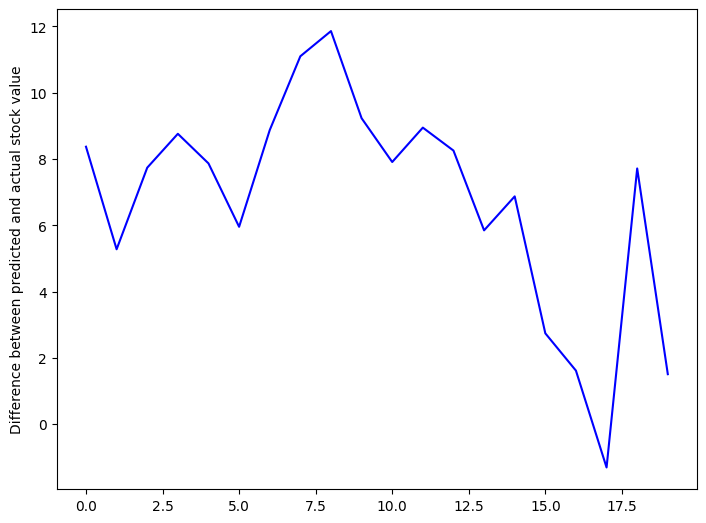

In [90]:
difference = actual_new - pred_new

fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:,3], 'b')
diffGraph.set_ylabel('Difference between predicted and actual stock value')
plt.xticks()
plt.show()

In [91]:
for seq,labels in test:
    print(seq.shape)
    break

(7, 4)
